<a href="https://colab.research.google.com/github/Jefffish09/MachineLearning/blob/dev/Classification/multiclass/bert_multiclass_tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

References:

* https://towardsdatascience.com/multi-label-multi-class-text-classification-with-bert-transformer-and-keras-c6355eccb63a

Data Source:

* https://www.kaggle.com/cfpb/us-consumer-finance-complaints


In [1]:
!pip install -U -q transformers

     |████████████████████████████████| 1.9MB 16.5MB/s 
     |████████████████████████████████| 890kB 54.2MB/s 
     |████████████████████████████████| 3.2MB 56.0MB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from transformers import TFBertModel, BertConfig, BertTokenizerFast
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

In [3]:
seed = 2021
max_len = 100
learning_rate=5e-05
epsilon = 1e-08
decay = 0.01
clipnorm = 1.0
batch_size = 64
epochs = 10
earlystopping_patience = 3
model_name = "bert-base-uncased"

In [4]:
# Import data from csv
df = pd.read_csv("/content/drive/MyDrive/consumer_complaints.csv", 
                usecols=("product", "consumer_complaint_narrative"),
                dtype={"consumer_complaint_narrative": object})

# Only interested in data with consumer complaints
df = df[df["consumer_complaint_narrative"].notnull()]
df = df[df["product"].notnull()]
df.reset_index(drop=True, inplace=True)
df = df.dropna()

df.head()

,product,consumer_complaint_narrative
0,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX ...
1,Consumer Loan,Due to inconsistencies in the amount owed that...
2,Mortgage,In XX/XX/XXXX my wages that I earned at my job...
3,Mortgage,I have an open and current mortgage with Chase...
4,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...


In [5]:
# Set your model output as categorical and save in new label col
df["product_label"] = pd.Categorical(df["product"])
df["product"] = df["product_label"].cat.codes
df.head()

,product,consumer_complaint_narrative,product_label
0,4,XXXX has claimed I owe them {$27.00} for XXXX ...,Debt collection
1,1,Due to inconsistencies in the amount owed that...,Consumer Loan
2,6,In XX/XX/XXXX my wages that I earned at my job...,Mortgage
3,6,I have an open and current mortgage with Chase...,Mortgage
4,6,XXXX was submitted XX/XX/XXXX. At the time I s...,Mortgage


In [6]:
labels_names_dict = dict(enumerate(df["product_label"].cat.categories))
labels = []
label_names = []
for i in labels_names_dict:
  labels.append(i)
  label_names.append(labels_names_dict[i])
print(labels_names_dict)

{0: 'Bank account or service', 1: 'Consumer Loan', 2: 'Credit card', 3: 'Credit reporting', 4: 'Debt collection', 5: 'Money transfers', 6: 'Mortgage', 7: 'Other financial service', 8: 'Payday loan', 9: 'Prepaid card', 10: 'Student loan'}


In [7]:
# Split into train and test - stratify over Issue
df_train, df_test = train_test_split(df, test_size=0.2, random_state=seed, stratify=df["product_label"])

df_train.head()

,product,consumer_complaint_narrative,product_label
55881,1,I was in a car accident and was dealing with b...,Consumer Loan
53666,3,I have already done a fraud alert I need my re...,Credit reporting
27439,6,I signed a modification offer submitted to me ...,Mortgage
61579,1,I believe that I was misled by PNC bank regard...,Consumer Loan
40505,3,Equifax does not respond to me in writing to p...,Credit reporting


In [8]:
def plot_perf(history):
  # Create a plot of accuracy and loss over time
  history_dict = history.history
  history_dict.keys()

  acc = history_dict["accuracy"]
  val_acc = history_dict["val_accuracy"]
  loss = history_dict["loss"]
  val_loss = history_dict["val_loss"]

  epochs = range(1, len(acc) + 1)

  # Training and validation loss
  plt.plot(epochs, loss, "r", label="Training loss")
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, "b", label="Validation loss")
  plt.title("Training and validation loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

  # Training and validation accuracy
  plt.plot(epochs, acc, "r", label="Training acc")
  plt.plot(epochs, val_acc, "b", label="Validation acc")
  plt.title("Training and validation accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(loc="lower right")
  plt.show()

In [9]:
# Load transformers config and set output_hidden_states to False
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path=model_name, config=config)

# Load the Transformers BERT model
transformer_model = TFBertModel.from_pretrained(model_name, config=config)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/10
669/669 [==============================] - 943s 1s/step - loss: 0.9797 - accuracy: 0.7026 - val_loss: 0.4911 - val_accuracy: 0.8529
Epoch 2/10
669/669 [==============================] - 928s 1s/step - loss: 0.4644 - accuracy: 0.8638 - val_loss: 0.4682 - val_accuracy: 0.8585
Epoch 3/10
669/669 [==============================] - 927s 1s/step - loss: 0.4016 - accuracy: 0.8828 - val_loss: 0.4634 - val_accuracy: 0.8601
Epoch 4/10
669/669 [==============================] - 927s 1s/step - loss: 0.3712 - accuracy: 0.8929 - val_loss: 0.4581 - val_accuracy: 0.8625
Epoch 5/10
669/669 [==============================] - 927s 1s/step - loss: 0.3542 - accuracy: 0.9007 - val_loss: 0.4599 - val_accuracy: 0.8622
Epoch 6/10
669/669 [==============================] - 928s 1s/step - loss: 0.3456 - accuracy: 0.9014 - val_loss: 0.4604 - val_accuracy: 0.8635
Epoch 7/10
669/669 [==============================] - 927s 1s/step - loss: 0.3241 - accuracy: 0.9082 - val_loss: 0.4617 - val_accuracy: 0.8628

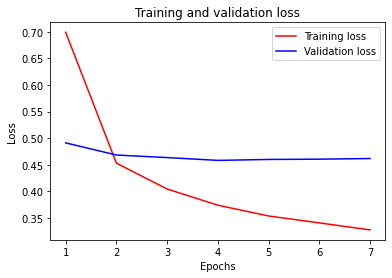

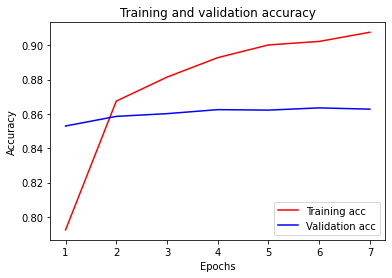

418/418 [==============================] - 90s 214ms/step - loss: 0.4564 - accuracy: 0.8622
                         precision    recall  f1-score   support

Bank account or service      0.850     0.770     0.808      1142
          Consumer Loan      0.757     0.701     0.728       736
            Credit card      0.812     0.845     0.828      1586
       Credit reporting      0.886     0.888     0.887      2505
        Debt collection      0.854     0.872     0.863      3511
        Money transfers      0.716     0.586     0.645       133
               Mortgage      0.928     0.956     0.942      2984
Other financial service      0.000     0.000     0.000        22
            Payday loan      0.632     0.414     0.500       145
           Prepaid card      0.771     0.785     0.778       172
           Student loan      0.840     0.878     0.859       426

               accuracy                          0.862     13362
              macro avg      0.731     0.700     0.712     13

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
#######################################
### ------- Train the model ------- ###

earlystop_callback = EarlyStopping(
  monitor="val_loss",
  min_delta=0.0001,
  patience=earlystopping_patience,
  restore_best_weights=True)

# Load the MainLayer
bert = transformer_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_len,), name="input_ids", dtype="int32")
inputs = {"input_ids": input_ids}

# Load the Transformers BERT model as a layer in a Keras model
bert_model = bert(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name="pooled_output")
pooled_output = dropout(bert_model, training=False)

# Then build your model output
product = Dense(units=len(df_train["product_label"].value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name="product")(pooled_output)
outputs = {"product": product}

# And combine it all in a model object
model = Model(inputs=inputs, outputs=outputs, name="BERT_MultiClass")

# Take a look at the model
# model.summary()

# Set an optimizer
optimizer = Adam(
    learning_rate=learning_rate,
    epsilon=epsilon,
    decay=decay,
    clipnorm=clipnorm)

# Set loss and metrics
loss = {"product": CategoricalCrossentropy(from_logits=True)}
metric = {"product": CategoricalAccuracy("accuracy")}

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=loss, 
    metrics=metric)

# Ready output data for the model
y_product = to_categorical(df_train["product"])

# Tokenize the input (takes some time)
x = tokenizer(
    text=df_train["consumer_complaint_narrative"].to_list(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors="tf",
    return_token_type_ids=False,
    return_attention_mask=False,
    verbose=True)

# Fit the model
history = model.fit(
    x={"input_ids": x["input_ids"]},
    y={"product": y_product},
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    callbacks=[earlystop_callback])

plot_perf(history)

#######################################
### ----- Evaluate the model ------ ###

# Ready test data
test_y_product = to_categorical(df_test["product"])
test_x = tokenizer(
    text=df_test["consumer_complaint_narrative"].to_list(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True, 
    return_tensors="tf",
    return_token_type_ids=False,
    return_attention_mask=False,
    verbose=True)

# Run evaluation
loss, acc = model.evaluate(
    x={"input_ids": test_x["input_ids"]},
    y={"product": test_y_product}
)

y_preds = []
predictions = model.predict(x={"input_ids": test_x["input_ids"]})
for prediction in predictions["product"]:
      y_preds.append(np.argmax(prediction))

y_true = np.argmax(test_y_product, axis=1)
report = classification_report(y_true=y_true, y_pred=y_preds, labels=labels, target_names=label_names, digits=3, output_dict=False)
print(report)